<a href="https://colab.research.google.com/github/SizhuangHe/FL-REU/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary

# Check assigned GPU
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Some Hyperparameters

In [47]:
input_size = 13
num_hidden_neuron = 5
num_classes = 1
output_size = num_classes

# Models

In [3]:
class IRIS_NN(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, output_size):
    super(IRIS_NN, self).__init__()

    self.l1 = nn.Linear(input_size, num_hidden_neurons)
    self.l2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.l3 = nn.Linear(num_hidden_neurons, output_size)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    out = self.l3(x)
    return out

# Load DataSet

## Prepare the Data

### Dataset setup

In [4]:
# df = pd.read_csv("Iris.csv")

# le=LabelEncoder()
# df['Species']=le.fit_transform(df['Species'])

# label=df['Species'].values

# scaler=StandardScaler()
# df = df.drop('Species',axis=1)
# df = df.drop('Id', axis=1)
# scaled_df=scaler.fit_transform(df)

# feature=scaled_df.astype(np.float32)

In [5]:
class IrisData(Dataset):
  def __init__(self, feature_train, label_train):
    self.feature = feature_train
    self.label = label_train

  def __len__(self):
    return len(self.label) 

  def __getitem__(self, idx):
    sample = self.feature[idx]
    return sample, self.label[idx]   

### Transform (Add Gaussian Noise)

In [6]:
def AddGaussianNoise(dataset, client_dict, client, mean, std):
  #loader = DataLoader(CustomDataset(dataset, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
  
  for data, label in CustomDataset(dataset, client_dict[client]):
    data += (torch.randn(len(data)) * std + mean).numpy()

In [7]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, sample):
#       sample += (torch.randn(sample.size) * self.std + self.mean).numpy()
#       return sample
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


### Other built-in dataset

#### MNIST

In [8]:
# transforms_mnist = transforms.Compose([
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.1307,), (0.3081,))
#                                        ])

# dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
# dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

#### sklearn Boston dataset (Regression)

In [28]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
feature = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]).astype(np.float32)
label = raw_df.values[1::2, 2].astype(np.float32)

scaler=StandardScaler()
feature = scaler.fit_transform(feature)

### Data preparation

In [11]:
feature_train,feature_test,label_train, label_test=train_test_split(feature, label,test_size=0.20,random_state=42)

In [12]:
dataset_train = IrisData(feature_train, label_train) # only the __init__ function is called here
dataset_test = IrisData(feature_test, label_test)

In [33]:
classes_test = [i for i in range(num_classes)]

# Partition the Data

In [14]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [15]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Randomly assign each client with  shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  client_dict_out = {}
  idxs = np.arange(len(dataset))
  #print(f"idxs: {idxs}")
  
  data_labels = dataset.label
  #data_labels = dataset.targets.numpy()
  #print(f"data_labels: {data_labels}")

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  #print(f"label_idx: {label_idxs}")
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  #print(f"label_idx new: {label_idxs}")
  idxs = label_idxs[0,:].astype(int)
  #print(f"idxs new: {idxs}")

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    #print(f"rand_set: {rand_set}")
    shard_idxs = list(set(shard_idxs) - rand_set)
    #print(f"shard_idxs: {shard_idxs}")

    for rand in rand_set:
      #print(f"to append: {idxs[rand*shards_size:(rand+1)*shards_size]}")
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]))

      set_i = set(client_dict[i])
      client_dict_out[i] = set_i
  return client_dict_out

In [16]:
def client_dict_train_val_split(client_dict_in, validation_ratio):
  """
  Split each client data randomly to two parts: training data and validation data

  param:
    - client_dict_in (python dictionary): the client dictionary
    - validation_ratio (double): the proportion of client data to be spitted into validation data

  returns:
    - dictionary of indices for each client's training and validation data  
  """
  client_dict_out = {}


  for client in client_dict_in:
    num_total_data = len(client_dict_in[client])
    num_val_data = int(num_total_data * validation_ratio)
    val_set = set(np.random.choice(np.array(list(client_dict_in[client])), num_val_data, replace=False))
    train_set = client_dict_in[client] - val_set
    client_dict_out[client]={}
    client_dict_out[client]["train"] = train_set
    client_dict_out[client]["validation"] = val_set
    
  return client_dict_out  

In [104]:
def seeClientMean(client_dict):
  """
  This function returns the mean of each client's local training set
  Can use this to roughly see how iid the dictionary is
  """
  mean = []

  for client in client_dict:
    loader =  DataLoader(CustomDataset(dataset_train, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
    ld = iter(loader).next()
    data, label = ld
    mean.append(torch.mean(label).item())

  #print(mean)  
  print("Variance of mean client data: ", np.var(mean))
  print("Note: a small value is expected for i.i.d partition.")

# Client Training


In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []

    

    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

# Server Training

In [18]:
def training(model, rounds, batch_size, num_classes,lr, ds, data_dict, C, K, E, plt_title, plt_color, report_accuracy):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False) # S_t is the array of clients to train on
    
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k]["train"])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w)) # take into account each client's number of data

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # validation
    model.eval()
    criterion = nn.MSELoss()
    print("-> Validation\n")
    for k in S_t:
      print(f"Validation on Client {k}")
      curr_round_val_loss = validate(model, dataset_train, data_dict[k]["validation"], criterion, num_classes, classes_test, report_accuracy)
    


  end = time.time()

  fig_train, ax_train = plt.subplots()
  x_axis_train = np.arange(1, rounds+1)
  y_axis_train = np.array(train_loss)
  ax_train.plot(x_axis_train, y_axis_train, 'tab:'+plt_color)

  ax_train.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax_train.grid()
  fig_train.savefig(plt_title+'.jpg', format='jpg')

  # fig_val, ax_val = plt.subplots()
  # x_axis_val = np.arange(1, rounds+1)
  # y_axis_val = np.array(val_loss)
  # ax_val.plot(x_axis_val, y_axis_val, 'tab:'+plt_color)

  # ax_val.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title=plt_title)
  # ax_val.grid()
  # fig_val.savefig(plt_title+'.jpg', format='jpg')

  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

In [19]:
def validate(model, dataset, val_idx, criterion,num_classes, classes, report_accuracy):
  batch_size = len(val_idx)
  val_loader = DataLoader(CustomDataset(dataset, val_idx), batch_size=len(val_idx), shuffle=True)
  return test(model, dataset, batch_size, criterion, num_classes, classes, val_loader, "Validation", report_accuracy=report_accuracy)

# Test

In [20]:
def test(model, dataset, bs, criterion, num_classes, classes, loader, mode, report_accuracy):
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  for data, labels in loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    if report_accuracy == True:
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      #print(f"data len: {len(data)}")
      #test accuracy for each object class
      for i in range(len(data)):
        label = labels.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1
        #print(f"i: {i}, label: {label}")

   
    
  # avg test loss
  test_loss = test_loss/len(loader.dataset)
  
  print(mode, "Loss: {:.6f}\n".format(test_loss))

  if report_accuracy == True:
    # print test accuracy
    for i in range(num_classes):
      if total_class[i]>0:
        print(mode, 'Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i]))) 

      else:
        print(mode, 'Accuracy of %5s: N/A (no '% (classes[i]), mode, ' examples)' )
      
    print('\nFinal ', mode, ' Accuracy: {:.3f} ({}/{})\n'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

  return test_loss

In [21]:
def testing(model, dataset, bs, criterion, num_classes, classes, report_accuracy):
  test_loader = DataLoader(dataset, batch_size=bs)
  
  model.eval()
  test(model, dataset, bs, criterion, num_classes, classes, test_loader, "Test", report_accuracy=report_accuracy)

# IID Case

## Training

Variance of mean client data:  3.8910993715906814
Note: a small value is expected for i.i.d partition.


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Round: 1... 	Average Loss: 1610.732
-> Validation

Validation on Client 5
Validation Loss: 245.871826

Validation on Client 6
Validation Loss: 152.186859

Validation on Client 8
Validation Loss: 52.466583

Validation on Client 4
Validation Loss: 54.444103

Validation on Client 2
Validation Loss: 323.605774

Validation on Client 9
Validation Loss: 227.673233

Validation on Client 0
Validation Loss: 26.693638

Validation on Client 7
Validation Loss: 115.548897

Validation on Client 1
Validation Loss: 349.207916

Validation on Client 3
Validation Loss: 59.470470



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Round: 2... 	Average Loss: 99.477
-> Validation

Validation on Client 2
Validation Loss: 192.560242

Validation on Client 0
Validation Loss: 52.105122

Validation on Client 4
Validation Loss: 72.607834

Validation on Client 9
Validation Loss: 150.828308

Validation on Client 6
Validation Loss: 139.626389

Validation on Client 7
Validation Loss: 54.932621

Validation on Client 8
Validation Loss: 28.089113

Validation on Client 3
Validation Loss: 43.128567

Validation on Client 5
Validation Loss: 148.228989

Validation on Client 1
Validation Loss: 252.037766

Round: 3... 	Average Loss: 79.685
-> Validation

Validation on Client 1
Validation Loss: 241.196854

Validation on Client 6
Validation Loss: 147.663696

Validation on Client 2
Validation Loss: 174.161041

Validation on Client 5
Validation Loss: 137.282608

Validation on Client 0
Validation Loss: 68.614754

Validation on Client 4
Validation Loss: 87.500343

Validation on Client 7
Validation Loss: 52.247677

Validation on Client 9
Val

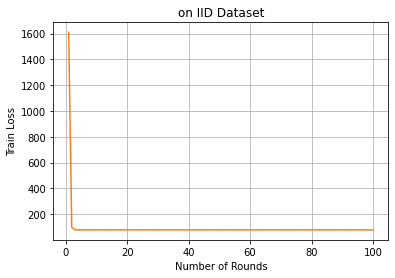

In [107]:
# number of training rounds
rounds = 100
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = iid_partition(dataset_train, K)
seeClientMean(client_dict)
iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)
# load model
model_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

if torch.cuda.is_available():
  model_iid.cuda()

model_iid_trained = training(model_iid, rounds, batch_size, num_classes, lr, dataset_train, iid_dict, C, K, E, "on IID Dataset", "orange", False)

## Testing

In [109]:
criterion = nn.MSELoss()
testing(model_iid_trained, dataset_test, K, criterion, num_classes, classes_test, False)


Test Loss: 75.506275



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Non IID training

Variance of mean client data:  75.92971209518882


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Round: 1... 	Average Loss: 544.095
-> Validation

Validation on Client 1
Validation Loss: 8.411114

Validation on Client 4
Validation Loss: 118.040009

Validation on Client 3
Validation Loss: 2.269212

Validation on Client 6
Validation Loss: 56.028355

Validation on Client 8
Validation Loss: 730.637451

Validation on Client 0
Validation Loss: 86.248917

Validation on Client 5
Validation Loss: 175.068787

Validation on Client 2
Validation Loss: 304.243927

Validation on Client 7
Validation Loss: 13.810813

Validation on Client 9
Validation Loss: 38.121349



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Round: 2... 	Average Loss: 61.971
-> Validation

Validation on Client 2
Validation Loss: 91.812088

Validation on Client 3
Validation Loss: 43.613464

Validation on Client 8
Validation Loss: 373.812439

Validation on Client 5
Validation Loss: 29.493017

Validation on Client 0
Validation Loss: 1.990823

Validation on Client 6
Validation Loss: 0.253320

Validation on Client 4
Validation Loss: 8.859260

Validation on Client 9
Validation Loss: 3.313006

Validation on Client 7
Validation Loss: 19.155659

Validation on Client 1
Validation Loss: 107.314880

Round: 3... 	Average Loss: 31.245
-> Validation

Validation on Client 7
Validation Loss: 34.394447

Validation on Client 0
Validation Loss: 0.137090

Validation on Client 2
Validation Loss: 65.508125

Validation on Client 9
Validation Loss: 10.892234

Validation on Client 4
Validation Loss: 2.251317

Validation on Client 6
Validation Loss: 3.832973

Validation on Client 3
Validation Loss: 65.719452

Validation on Client 5
Validation Loss: 

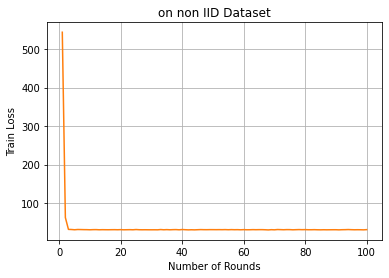

In [103]:
# number of training rounds
rounds = 100
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = non_iid_partition(dataset_train, clients=K, total_shards=10, shards_size=40, num_shards_per_client=1) # every client is given only one shard, which is very non_iid 
seeClientMean(client_dict)
non_iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)

# loader =  DataLoader(CustomDataset(dataset_train, client_dict[0]), batch_size=len( client_dict[0]), shuffle=True)
# ld = iter(loader).next()
# data, label = ld
# print("data: ", data, "label: ", label)
#load model
model_non_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

if torch.cuda.is_available():
  model_non_iid.cuda()

model_non_iid_trained = training(model_non_iid, rounds, batch_size, num_classes,lr, dataset_train, non_iid_dict, C, K, E, "on non IID Dataset", "orange", False)

## Test

In [108]:
criterion = nn.MSELoss()
testing(model_non_iid_trained, dataset_test, 10, criterion, num_classes, classes_test, False)

Test Loss: 74.590375



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
